#### Prerequisite Libraries

In [1]:
!pip install qiskit qiskit-aer mthree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 518.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.3/343.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 k

#### Code and Output


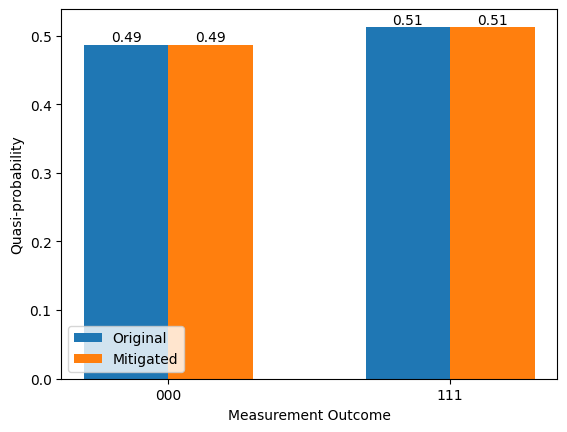

In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import  Aer
from mthree import M3Mitigation
import matplotlib.pyplot as plt
import numpy as np

qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.measure_all()

backend = Aer.get_backend('aer_simulator')
qc = transpile(qc, backend)
result = backend.run(qc, shots=1000).result()

raw_counts = result.get_counts()

mit = M3Mitigation(backend)
mit.cals_from_system([0, 1, 2])
mit_counts = mit.apply_correction(raw_counts, qubits=[0, 1, 2])

def plot_distribution(original_counts, mitigated_counts):
    labels = list(original_counts.keys())
    original_probs = [original_counts.get(label, 0) / sum(original_counts.values()) for label in labels]
    mitigated_probs = [mitigated_counts.get(label, 0) for label in labels]

    x = np.arange(len(labels))  # x-axis positions
    width = 0.3
    fig, ax = plt.subplots()

    original_bars = ax.bar(x - width / 2, original_probs, width, label='Original')
    mitigated_bars = ax.bar(x + width / 2, mitigated_probs, width, label='Mitigated')

    for bars in [original_bars, mitigated_bars]:
        for bar in bars:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}',
                    ha='center', va='bottom')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel('Measurement Outcome')
    ax.set_ylabel('Quasi-probability')
    ax.legend()
    plt.show()

plot_distribution(raw_counts, mit_counts)


In [4]:
import random

def calculate_parity_bits(data_bits):
    """Calculate the required number of parity bits for a given data size."""
    m = len(data_bits)
    r = 0
    while (2 ** r) < (m + r + 1):
        r += 1
    return r

def hamming_encode(data_bits):
    """Encodes the data bits using Hamming Code and inserts parity bits."""
    m = len(data_bits)
    r = calculate_parity_bits(data_bits)
    n = m + r

    encoded_bits = []
    j = 0  
    for i in range(1, n + 1):
        if i & (i - 1) == 0:  
            encoded_bits.append(0) 
        else:
            encoded_bits.append(int(data_bits[j]))
            j += 1

    for i in range(r):
        parity_position = (2 ** i) - 1
        parity = 0
        for j in range(parity_position, n, 2 * (parity_position + 1)):
            parity ^= sum(encoded_bits[j:j + parity_position + 1])
        encoded_bits[parity_position] = parity

    return encoded_bits

def introduce_error(encoded_bits):
    """Introduces a single-bit error at a random position in the encoded bits."""
    error_position = random.randint(0, len(encoded_bits) - 1)
    encoded_bits[error_position] ^= 1  # Flip the bit to introduce error
    return error_position

def hamming_decode(encoded_bits):
    """Detects and corrects any single-bit error in the encoded bits."""
    n = len(encoded_bits)
    error_position = 0

    for i in range(int.bit_length(n)):
        parity_position = (2 ** i) - 1
        parity = 0
        for j in range(parity_position, n, 2 * (parity_position + 1)):
            parity ^= sum(encoded_bits[j:j + parity_position + 1])
        if parity != 0:
            error_position += parity_position + 1

    if error_position > 0:
        print(f"Error detected at position {error_position}. Correcting it.")
        encoded_bits[error_position - 1] ^= 1
    else:
        print("No error detected.")

    data_bits = []
    for i in range(1, n + 1):
        if not (i & (i - 1) == 0):  
            data_bits.append(encoded_bits[i - 1])

    return data_bits


data_bits = "1011"  
print("Original data bits:", data_bits)

encoded_bits = hamming_encode(data_bits)
print("Encoded bits with parity:", encoded_bits)

error_position = introduce_error(encoded_bits)
print(f"Encoded bits after introducing error at position {error_position + 1}:", encoded_bits)

decoded_data = hamming_decode(encoded_bits)
print("Decoded data bits after error correction:", "".join(map(str, decoded_data)))


Original data bits: 1011
Encoded bits with parity: [0, 3, 1, 2, 0, 1, 1]
Encoded bits after introducing error at position 7: [0, 3, 1, 2, 0, 1, 0]
Error detected at position 7. Correcting it.
Decoded data bits after error correction: 1011
